# 3D Neural Style Transfer, simultaneous reshaping and texturing

This is the Jupyter Notebook for 3D neural style transfer. The goal is to transfer style from a 2D style image onto a 3D mesh, either reshaping the mesh or texturing the mesh. The mesh has no UV map or texture map at the beginning.

In this notebook, reshaping and texturing are conducted simultaneously. In other words, in each optimization iteration, both per-vertex position offset and per-vertex color are optimized. Experiment results show that even if reshaping and texturing are done at same time, they are not aligned to each other.

This notebook can be directly run on Google Colab without additional effort. For acceleration it is helpful to use a GPU runtime.

## Step 0: imports

In [1]:
import sys
import torch

# install PyTorch3D
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install -q pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.utils import ico_sphere, torus
from pytorch3d.renderer import TexturesVertex

# install KeOps kernels
!pip install -q pykeops==1.4.1 # > install.log

# install pytorch version of np.Interp, which is used for histogram loss
!pip install -q git+https://github.com/aliutkus/torchinterp1d.git

# Please run the following two lines DEPENDENTLY! (depends on whether the notebook is run locally or on Colab)
!git clone https://github.com/wmd0701/MA.git NST
%cd NST
!mkdir runtime_objs # directory that stores obj files generated during optimization

# import self-defined functions
from utils.data_loader import image_loader, image_unloader
from utils.pipeline import pipeline_3D_NST_simultaneous
from utils.mesh_preprocess import plot_pointcloud
from utils.plot import plot_loss
from utils.renderer import grid_plot, single_plot

# better plot
%pylab inline

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     |████████████████████████████████| 44.7 MB 2.9 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 10.8 MB/s 
     |████████████████████████████████| 319 kB 5.2 MB/s 
Cloning into 'NST'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 163 (delta 67), reused 121 (delta 27), pack-reused 0
Receiving objects: 100% (163/163), 21.19 MiB | 33.48 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/NST
Populating the interactive namespace from numpy and matplotlib


## Step 1: load images

torch.Size([1, 3, 256, 384])


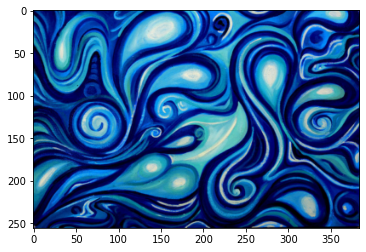

In [2]:
style_img = image_loader("./image_style/blue_swirls.jpg", imsize=256, tiling=1, freq_lower=None, freq_upper=None)

print(style_img.shape)
imshow(image_unloader(style_img));show()

## Step 2: load mesh

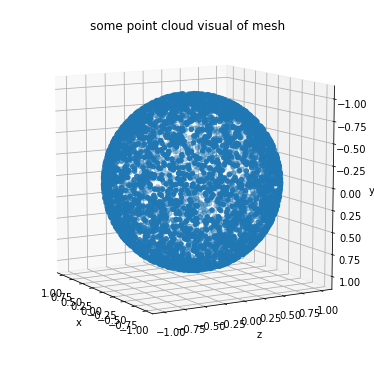

In [3]:
# generate an ico sphere mesh using PyTorch3D API, or just load it from repository
# org_mesh = ico_sphere(7, device)
org_mesh = load_objs_as_meshes(["meshes/ico_sphere_level7.obj"], device=device)

# have some visualization on point cloud, not necessary
plot_pointcloud(org_mesh, title = "some point cloud visual of mesh")

## Step 3: run neural style transfer pipeline

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


no cameras are given, and sampling_cameras is False
number of cameras: 1


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

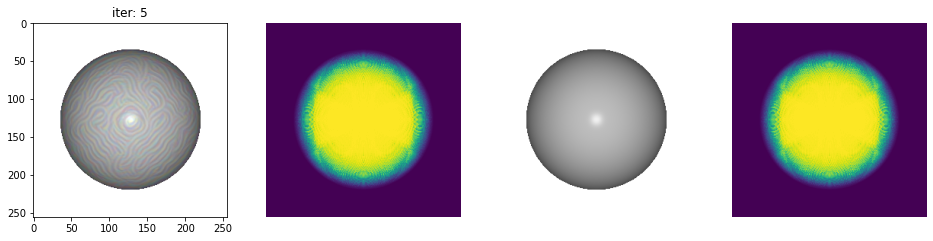

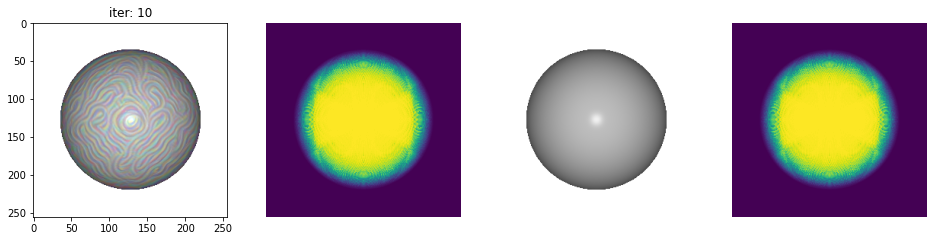

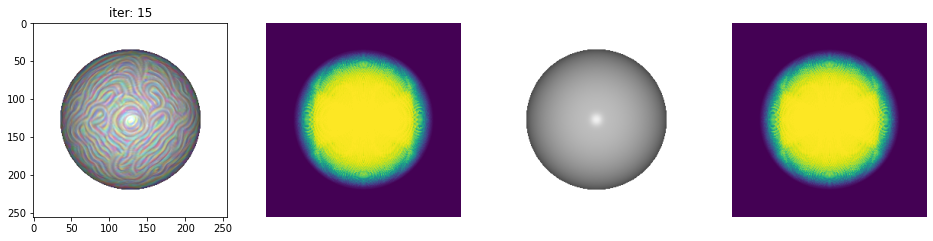

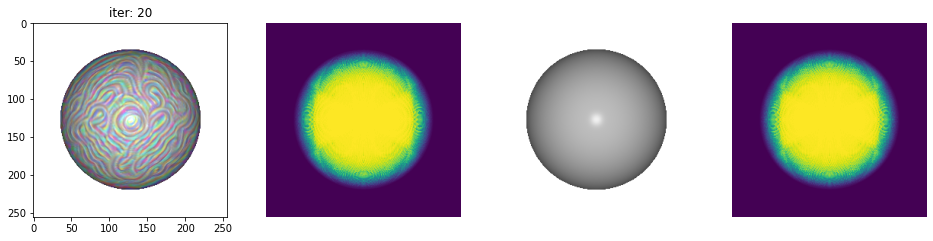

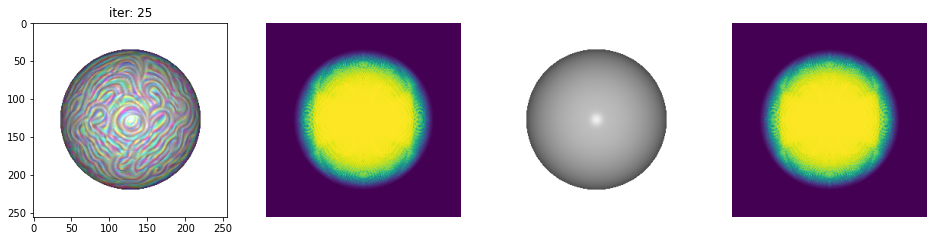

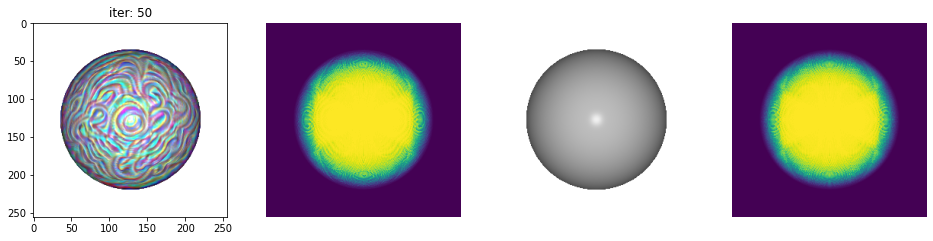

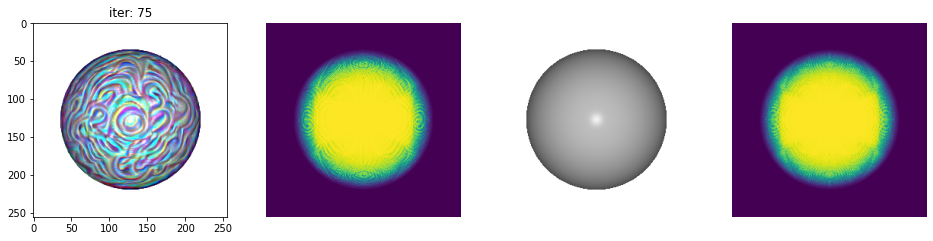

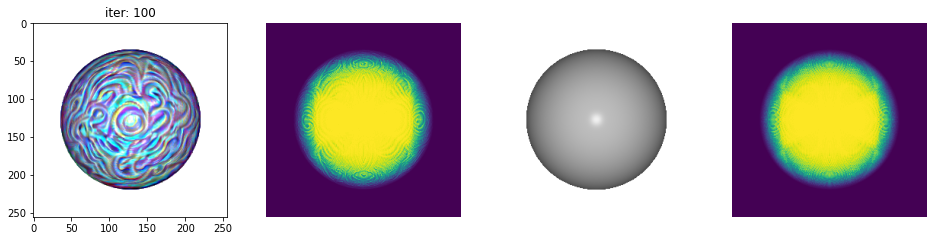

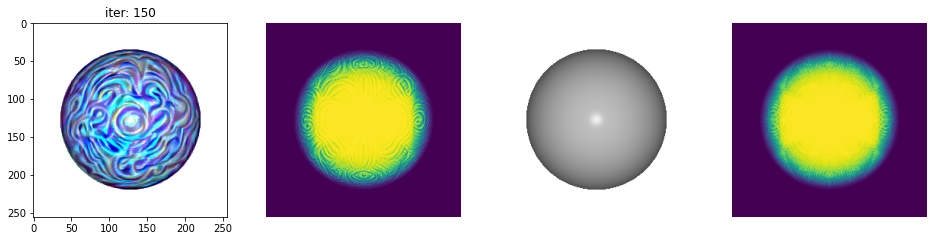

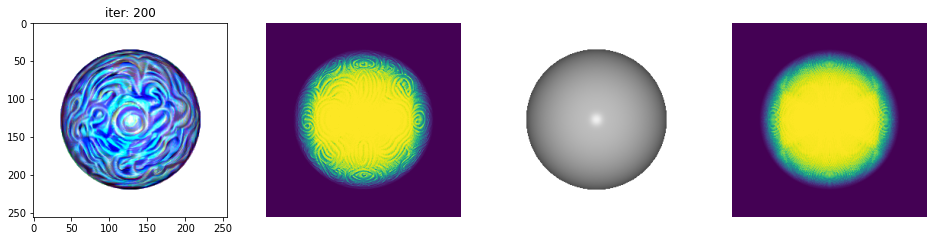

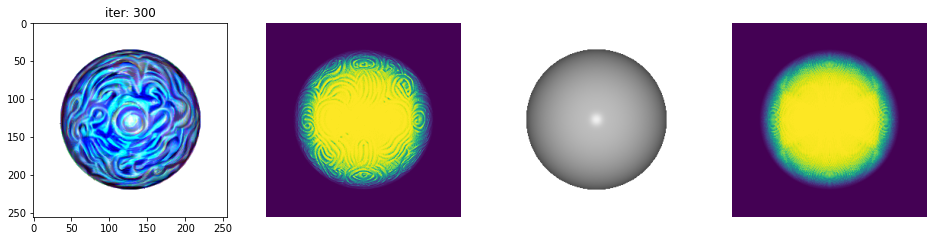

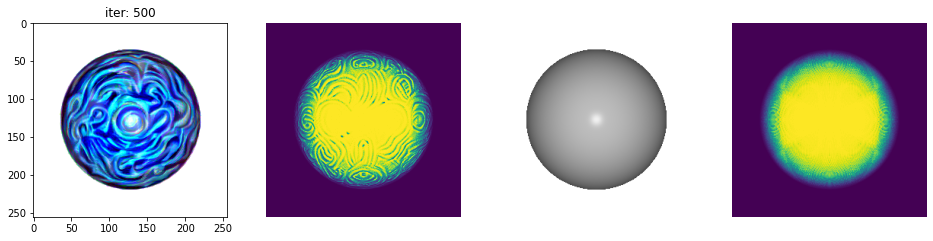

In [4]:
# reload image and mesh
org_mesh = ico_sphere(7, device)
style_img = image_loader("./image_style/blue_swirls.jpg", imsize = 256)

# style layers and weights
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
style_weights = [1e6/n**2 for n in [64,128,256,512]]

# image size of rendering
rendering_size = 256

# style loss types and corresponding weights
style_loss_types = {'gram': 1,
                    #'bnst':1,
                    #'morest':1,
                    #'histo':1,
                    #'poly':1,
                    #'linear':1,
                    #'rbf':1e2
                    }

# camera settings
# by default, only using a single fixed camera, thus only small part of mesh is stylized
# you can use more cameras by either setting sampling_cameras to True, or adding more camera positions in elevs and azims
# when using more cameras, increase n_iterations respectively
sampling_cameras = False
elevs = torch.tensor([0])
azims = torch.tensor([0])                  
perspective_camera = True
camera_dist = 2.7
faces_per_pixel = 50
n_views_per_iter = 4

# number of iterations and learning rate
n_iterations = 500
reshaping_lr = 1e-5
texturing_lr = 1e-2

# plot rendering and save mesh at specific iterations
plot_period = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500, 2000]

# masking
masking = False
mask_pooling = 'avg'

# max or avg pooling
model_pooling = 'max'

# whether compel color in range [0, 1] for texturing
clamping = False

# pipeline                                                                    
verts_offsets, verts_colors, loss_history_reshaping, loss_history_texturing, rendering_at_iter = pipeline_3D_NST_simultaneous( 
                                                                              org_mesh,
                                                                              style_img,
                                                                              rendering_size = rendering_size,
                                                                              style_layers = style_layers,
                                                                              style_weights = style_weights,
                                                                              n_views_per_iter = n_views_per_iter, 
                                                                              cameras = None,
                                                                              sampling_cameras = sampling_cameras,
                                                                              elevs = elevs,
                                                                              azims = azims,   
                                                                              perspective_camera = perspective_camera,
                                                                              camera_dist = camera_dist,
                                                                              faces_per_pixel = faces_per_pixel,
                                                                              n_iterations = n_iterations, 
                                                                              reshaping_lr = reshaping_lr,
                                                                              texturing_lr = texturing_lr,
                                                                              plot_period = plot_period,
                                                                              style_loss_types = style_loss_types,
                                                                              masking = masking,
                                                                              model_pooling = model_pooling,
                                                                              mask_pooling = mask_pooling,
                                                                              clamping = clamping,
                                                                              )

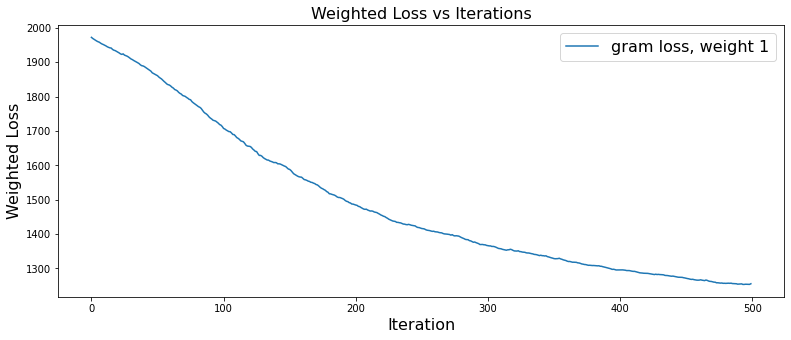

In [5]:
# plot loss for reshaping
plot_loss(loss_history_reshaping, loss_name = None, start = 0, end = n_iterations)

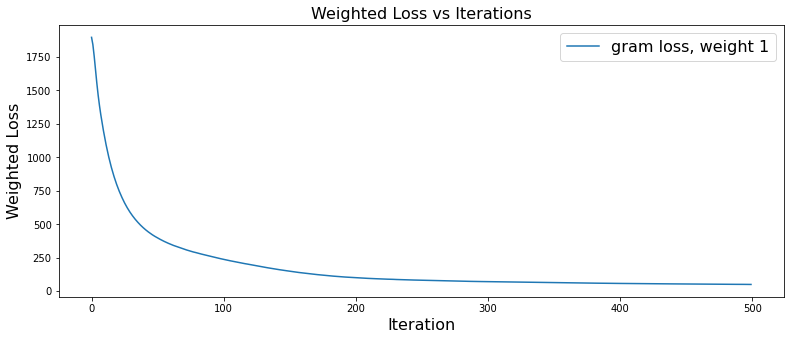

In [6]:
# plot loss for texturing
plot_loss(loss_history_texturing, loss_name = None, start = 0, end = n_iterations)

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


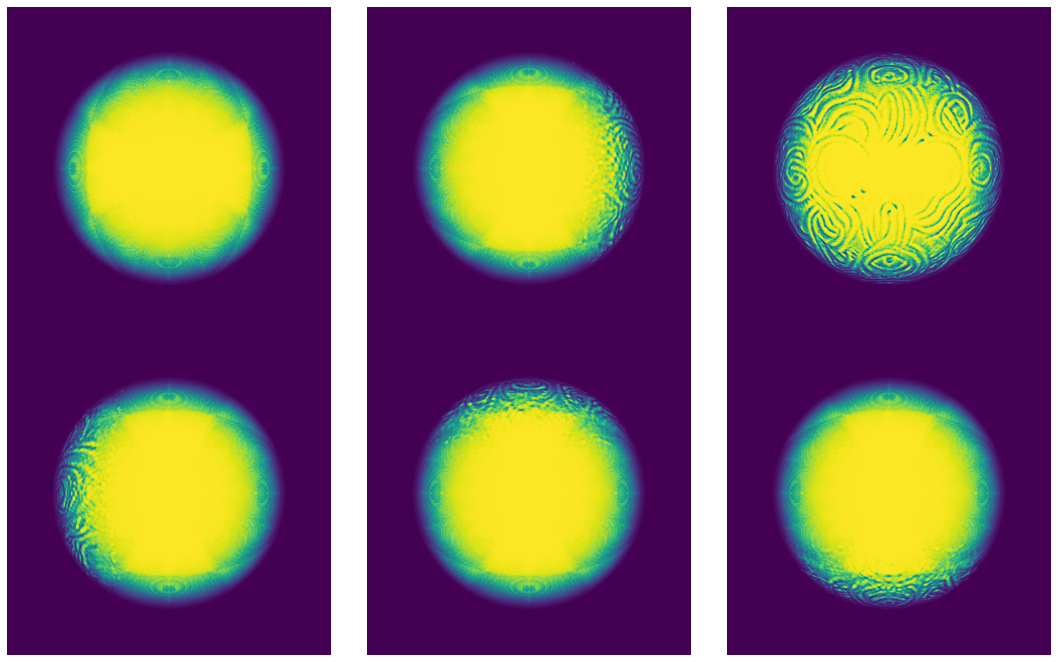

In [7]:
# more views of mesh, silhouettes
plot_mesh = ico_sphere(7, device)
plot_mesh.offset_verts_(verts_offsets)
grid_plot(plot_mesh, sil_shader = True, rgb = False)

In [ ]:
# more views of mesh
plot_mesh = ico_sphere(7, device)
plot_mesh.offset_verts_(verts_offsets)
plot_mesh.textures = TexturesVertex(verts_features = verts_colors.detach())
grid_plot(plot_mesh, sil_shader = False, rgb = True)